**Step 1 :**

Loading the data

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/HousePricePrediction.csv')
df.head()

,Id,MSSubClass,MSZoning,LotArea,LotConfig,BldgType,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,BsmtFinSF2,TotalBsmtSF,SalePrice
0,0,60,RL,8450,Inside,1Fam,5,2003,2003,VinylSd,0.0,856.0,208500.0
1,1,20,RL,9600,FR2,1Fam,8,1976,1976,MetalSd,0.0,1262.0,181500.0
2,2,60,RL,11250,Inside,1Fam,5,2001,2002,VinylSd,0.0,920.0,223500.0
3,3,70,RL,9550,Corner,1Fam,5,1915,1970,Wd Sdng,0.0,756.0,140000.0
4,4,60,RL,14260,FR2,1Fam,5,2000,2000,VinylSd,0.0,1145.0,250000.0


**Step 2 :**

Undrestanding the data

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            2919 non-null   int64  
 1   MSSubClass    2919 non-null   int64  
 2   MSZoning      2915 non-null   object 
 3   LotArea       2919 non-null   int64  
 4   LotConfig     2919 non-null   object 
 5   BldgType      2919 non-null   object 
 6   OverallCond   2919 non-null   int64  
 7   YearBuilt     2919 non-null   int64  
 8   YearRemodAdd  2919 non-null   int64  
 9   Exterior1st   2918 non-null   object 
 10  BsmtFinSF2    2918 non-null   float64
 11  TotalBsmtSF   2918 non-null   float64
 12  SalePrice     1460 non-null   float64
dtypes: float64(3), int64(6), object(4)
memory usage: 296.6+ KB


Here is a description of columns in dataframe :   

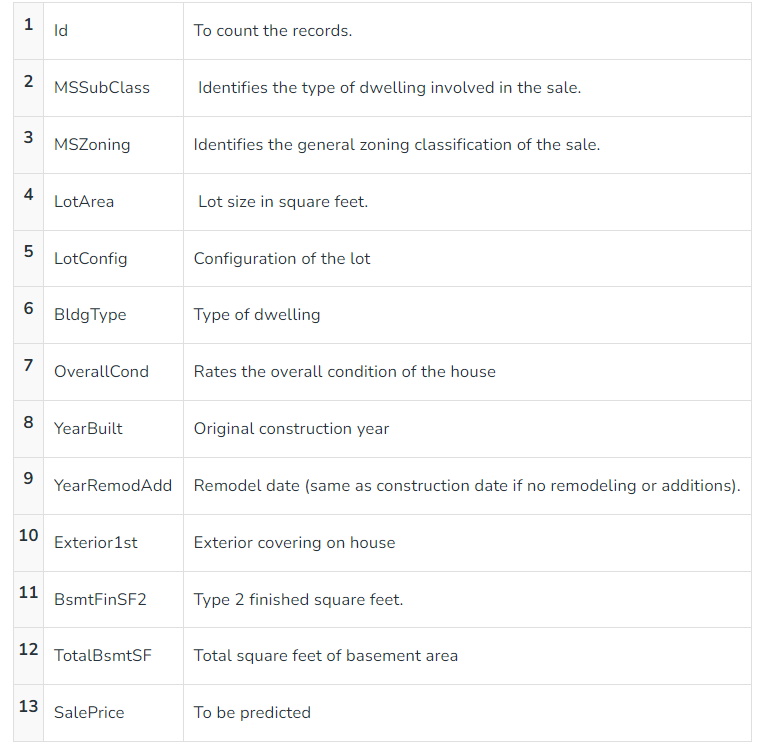





*   There are 13 columns, including 4 categorical & 9 numerical, and 2919 rows of data.
*   There are some missing values in these columns that need to be handled : MSZoning, Exterior1st, BsmtFinSF2, TotalBsmtSF, SalePrice



Most of machine learning models don't accept categorical data. to deal with them, first we need to know how many unique vales each categorical column has.

The first 3 columns have only 5 different values so we can use one-hot encoding for them. but the last col has 15 different values which is a lot to be OH encoded, so we're just going to delete that column.

OH encoding needs to be done after train_test split to prevent data leakage.


In [3]:
# finding categorical & numerical cols
categorical_cols = df.select_dtypes(include='object').columns
print(categorical_cols)

numerical_cols = df.select_dtypes(exclude='object').columns
print(numerical_cols)

# number of unique values in each categorical column
df[categorical_cols].nunique()


Index(['MSZoning', 'LotConfig', 'BldgType', 'Exterior1st'], dtype='object')
Index(['Id', 'MSSubClass', 'LotArea', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF2', 'TotalBsmtSF', 'SalePrice'],
      dtype='object')


MSZoning        5
LotConfig       5
BldgType        5
Exterior1st    15
dtype: int64

**Step 3 :**     

Data Cleaning

To deal with missing values, we can impute those missing in SalePrice with the mean.
and for other columns we can delete the records with missing values since null values are very few in each column.

In [4]:
# replacing missing values with 'mean' in SalePrice
df['SalePrice'].fillna(df['SalePrice'].mean(), inplace=True)

# removing other ramining rows with missing values
df.dropna(inplace=True)

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2913 entries, 0 to 2918
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            2913 non-null   int64  
 1   MSSubClass    2913 non-null   int64  
 2   MSZoning      2913 non-null   object 
 3   LotArea       2913 non-null   int64  
 4   LotConfig     2913 non-null   object 
 5   BldgType      2913 non-null   object 
 6   OverallCond   2913 non-null   int64  
 7   YearBuilt     2913 non-null   int64  
 8   YearRemodAdd  2913 non-null   int64  
 9   Exterior1st   2913 non-null   object 
 10  BsmtFinSF2    2913 non-null   float64
 11  TotalBsmtSF   2913 non-null   float64
 12  SalePrice     2913 non-null   float64
dtypes: float64(3), int64(6), object(4)
memory usage: 318.6+ KB


In [5]:
# deleting column with 15 different categorical values
df.drop('Exterior1st', axis=1, inplace=True)

**Step 4 :**    

Building a Model

Before we start building our model we need to split our train data and apply OH encoder

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# defining target variable and features
y = df['SalePrice']
X = df.drop('SalePrice', axis=1, inplace=False)

X_train, X_valid, y_train, y_valid = train_test_split(X, y,random_state=1)


# finding categorical & numerical cols
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

# One-Hot encoding
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_train_cols = pd.DataFrame(OH_encoder.fit_transform(X_train[categorical_cols]))
OH_valid_cols = pd.DataFrame(OH_encoder.transform(X_valid[categorical_cols]))

# reseting the indexes
OH_train_cols.index = X_train.index
OH_valid_cols.index = X_valid.index

# putting cols together
OH_X_train = pd.concat([X_train[numerical_cols], OH_train_cols], axis=1)
OH_X_valid = pd.concat([X_valid[numerical_cols], OH_valid_cols], axis=1)

# resetting dtypes to string
OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


we're going to use a couple of machine learning models including : Random forests, XGBoost regressor & Linear regression

Then we're gonna use cross validation to compare the results and see which one works the best.



In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# training the model with random forests
model_one = RandomForestRegressor(random_state=1)
model_one.fit(OH_X_train, y_train)

# predicting target for validation data
pred_one = model_one.predict(OH_X_valid)

# calculating the loss function and accuracy
MAE_one = mean_absolute_error(y_true = y_valid, y_pred = pred_one)
accuracy_one = r2_score(y_true = y_valid, y_pred = pred_one)

print(MAE_one, "\n", accuracy_one)



11982.575275269515 
 0.8128487648482201


In [9]:
from sklearn.linear_model import LinearRegression

# training the model with linear regression
model_two = LinearRegression()
model_two.fit(OH_X_train, y_train)

# predictin results for validation data
pred_two = model_two.predict(OH_X_valid)

# calculating the loss function and accuracy
MAE_two = mean_absolute_error(y_true = y_valid, y_pred = pred_two)
accuracy_two = r2_score(y_true = y_valid, y_pred = pred_two)

print(MAE_two, "\n", accuracy_two)


32634.515352125418 
 0.33887900215560596


In [10]:
!pip install xgboost

In [28]:
from xgboost import XGBRegressor

# training the model with XGBoost regressor
model_three = xgb.XGBRegressor(learning_rate = 0.01, n_estimators = 1000)
model_three.fit(OH_X_train, y_train)

# predictin results for validation data
pred_three = model_three.predict(OH_X_valid)

# calculating the loss function and accuracy
MAE_three = mean_absolute_error(y_true = y_valid, y_pred = pred_three)
accuracy_three = r2_score(y_true = y_valid, y_pred = pred_three)

print(MAE_three, "\n", accuracy_three)

12665.79277825636 
 0.8028253955073497


From the results above it is clear that random forset regressor model has the best performance on this data so we will use that to predict sale price for new houses.